<a href="https://colab.research.google.com/github/MariuszGrecki/Machine_learning_tutorial/blob/main/classification/02_k_neighbors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasyfikacja K-najbliższych sąsiadów

wykorzystujemy wzór odległości euklidesowej
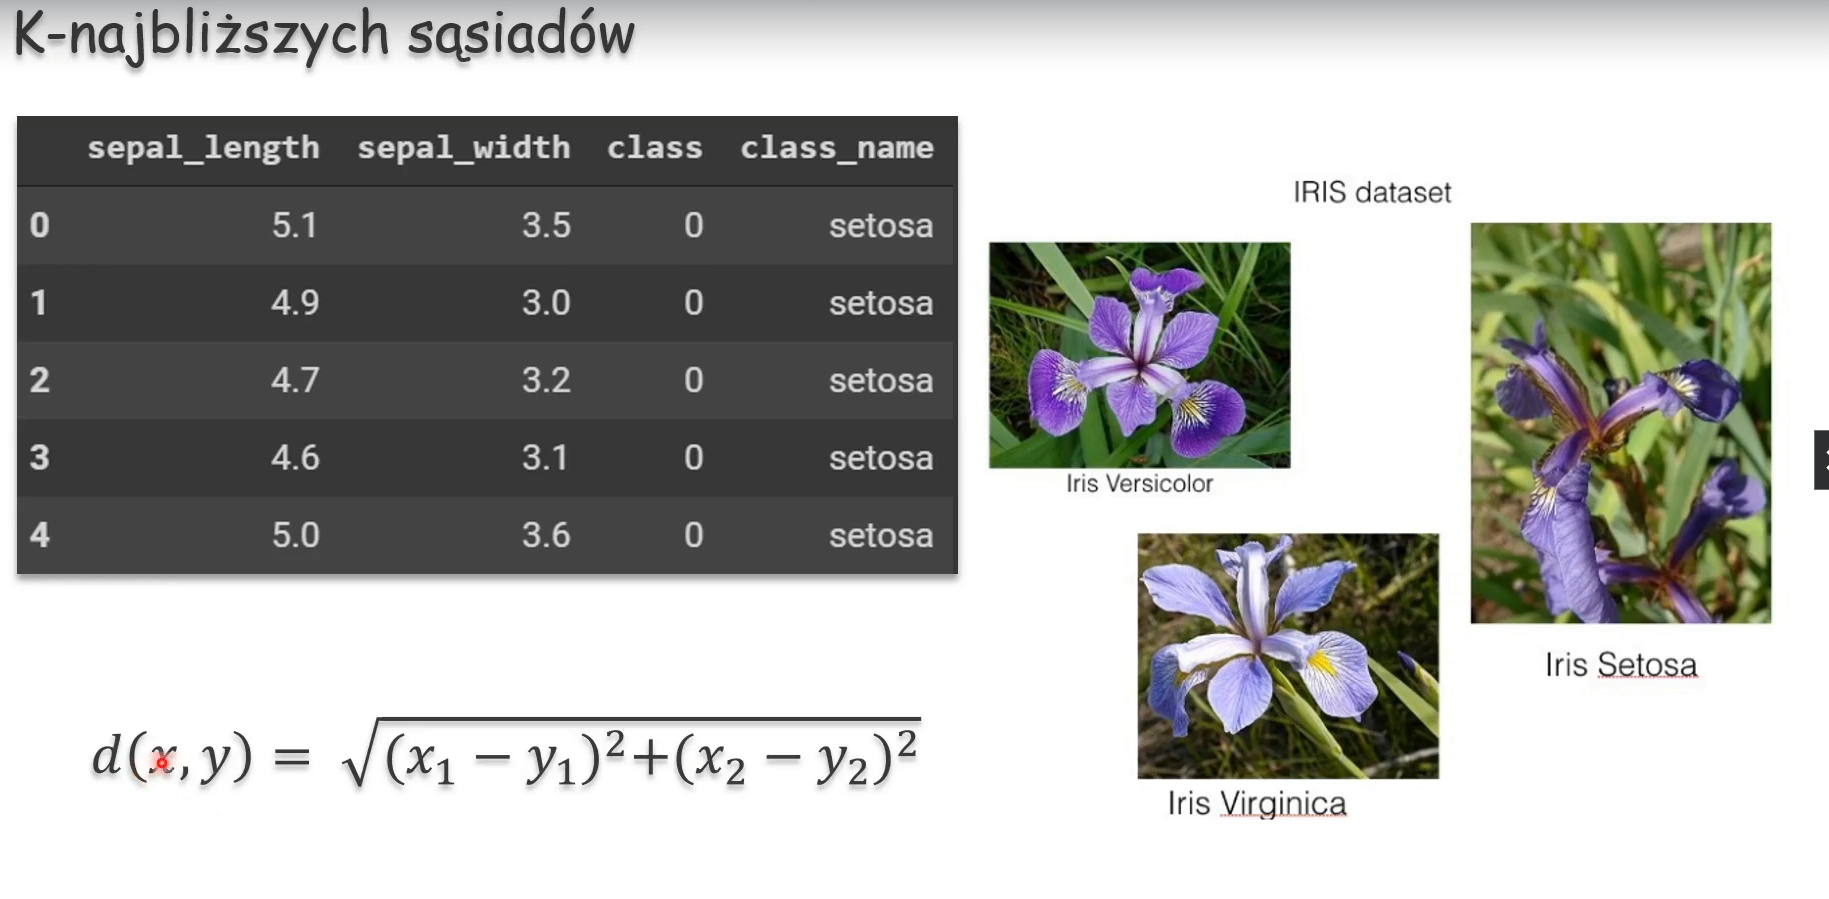

na podstawie danych tworzymy wykres punktowy, 3 klasy setosa, versicolor, virginca -> gatunki irysów :D, k informuje nas o tym ile sasiadów bierzemy pod uwagę w tym przypadku k=3, na podstawie 3 najbliższych sąsiadów i klasy jaka tam się znajduje przypisujemy próbkę do tej klasy
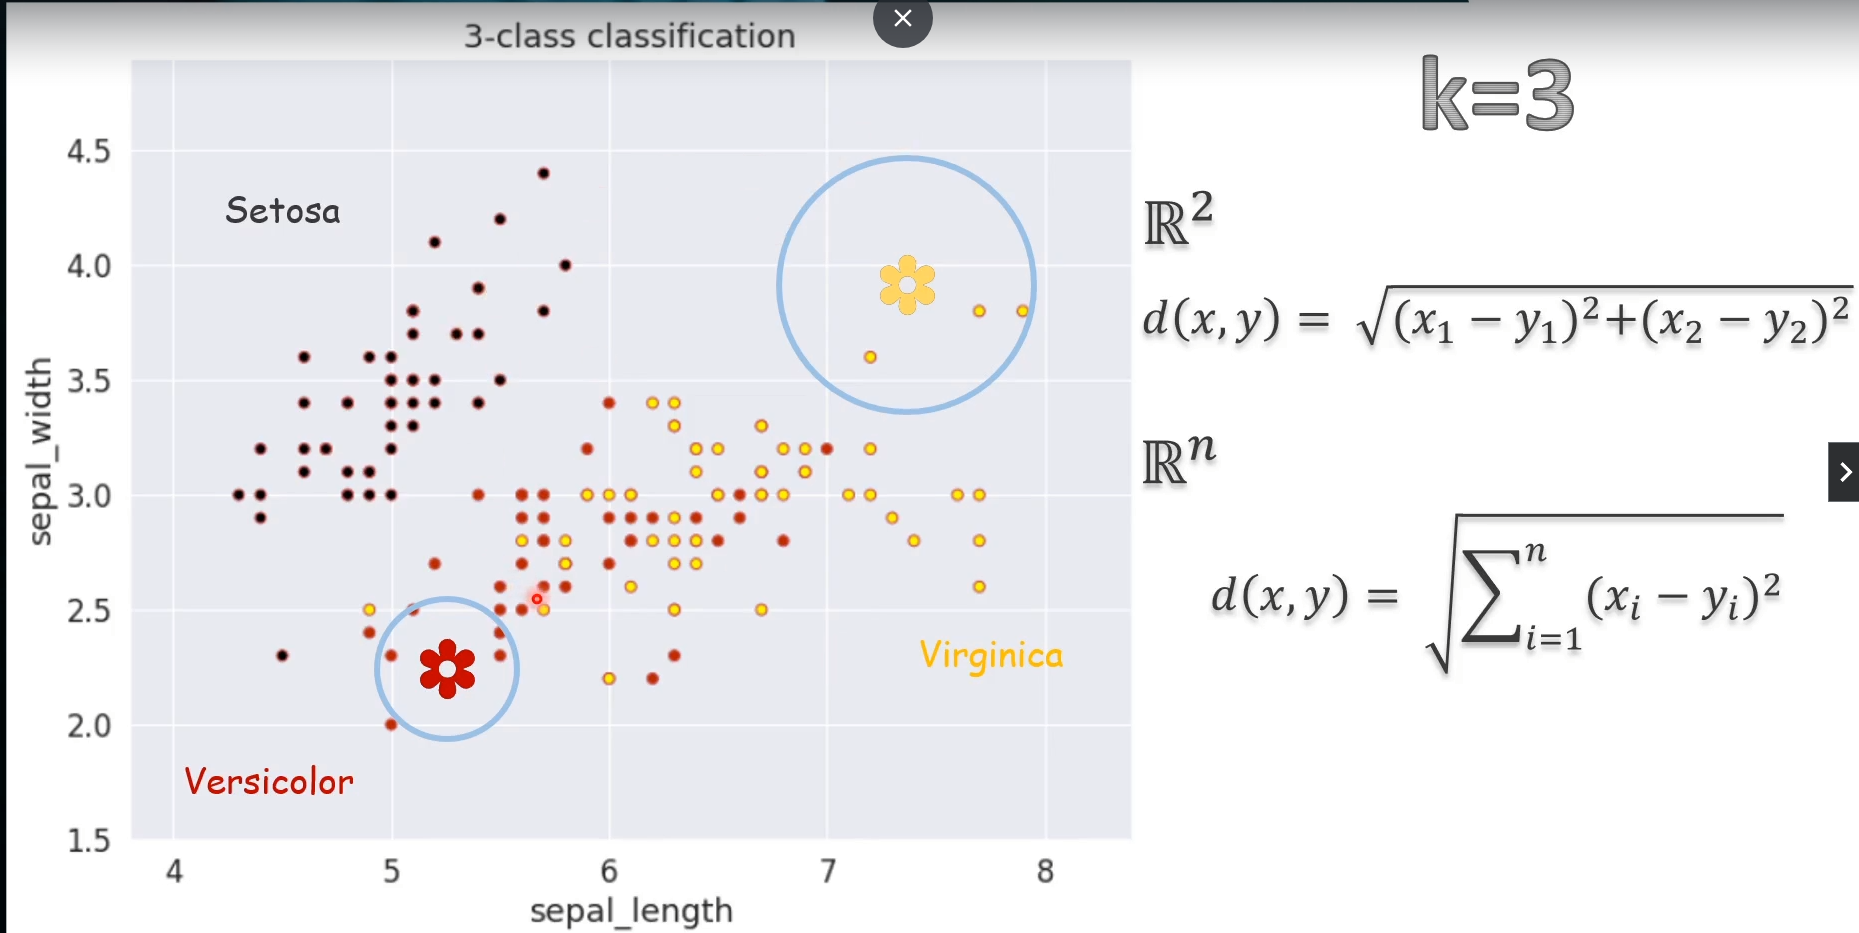

**Granice decyzyjne**

można wyświetlic granice decyzyjne, jak ustalic konkretna liczbe sąsiadów? dzięki metodze przeszukiwania siatki

- przykład z 15 sąsiadami
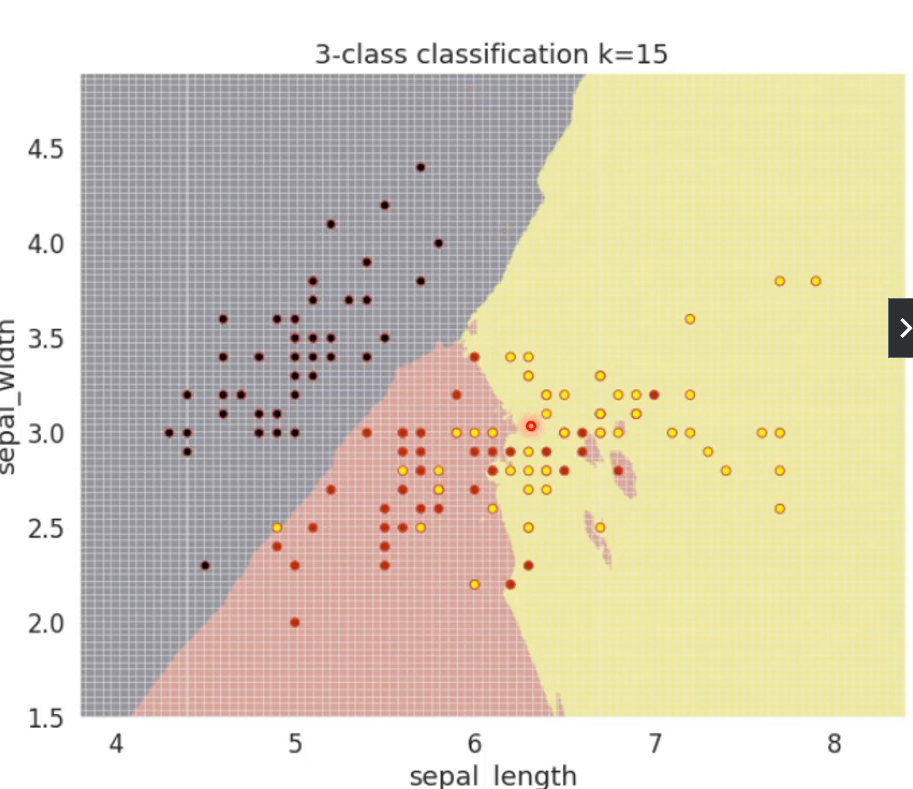

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

np.random.seed(42)
sns.set(font_scale=1.3)

In [3]:
#wczytywanie danych
from sklearn.datasets import load_iris
raw_data = load_iris()
raw_data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [5]:
all_data = raw_data.copy()
data = all_data['data']
target = all_data['target']

print(f'{data[:5]}\n')
print(f'{target[:5]}')

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]

[0 0 0 0 0]


In [6]:
all_data['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [8]:
df = pd.DataFrame(data=np.c_[data, target], columns=all_data['feature_names'] + ['target'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5
target,150.0,1.000000,0.819232,0.0,0.0,1.00,2.0,2.0


In [11]:
df['target'].value_counts()

target
0.0    50
1.0    50
2.0    50
Name: count, dtype: int64

In [ ]:
#wykres rozproszenia

In [12]:
#jakie mamy kolumny
df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')

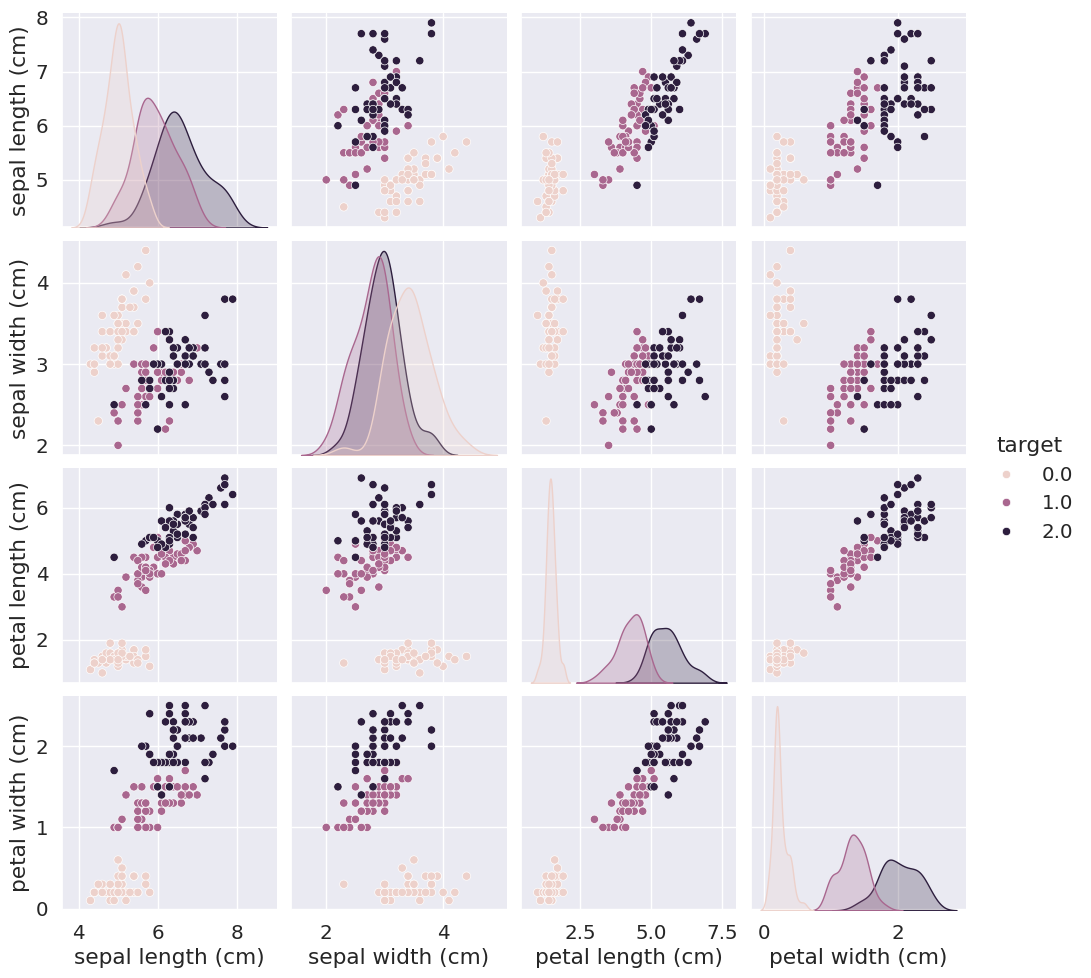

In [14]:
_ = sns.pairplot(df, vars=all_data['feature_names'], hue='target')

In [ ]:
#na tych wykresach możemy sprawdzić za pomoca których zmiennych możemy łatwo wykonać sprawdzanie

In [15]:
df.corr() #korelacje

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
sepal length (cm),1.000000,-0.117570,0.871754,0.817941,0.782561
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126,-0.426658
petal length (cm),0.871754,-0.428440,1.000000,0.962865,0.949035
petal width (cm),0.817941,-0.366126,0.962865,1.000000,0.956547
target,0.782561,-0.426658,0.949035,0.956547,1.000000


In [16]:
#wycinamy dane do 2 pierwszych kolumn aby nie było za łątwo :P (lepiej wziąc 2 ostatnie)
data = data[: ,:2]

print('data shape:', data.shape)
print('target shape:', target.shape)

data shape: (150, 2)
target shape: (150,)


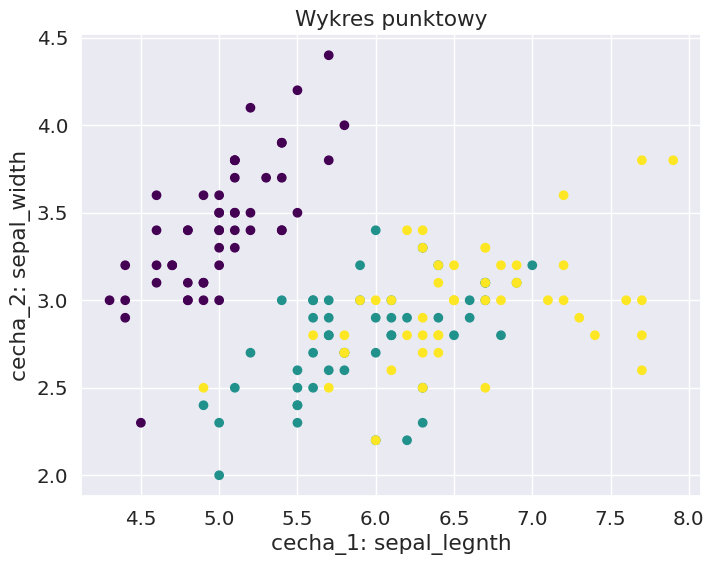

In [17]:
#wykres punktowy z sepal_length oraz sepal_width
plt.figure(figsize=(8,6))
plt.scatter(data[:, 0], data[:, 1], c=target, cmap='viridis')
plt.title('Wykres punktowy')
plt.xlabel('cecha_1: sepal_legnth')
plt.ylabel('cecha_2: sepal_width')
plt.show()

In [18]:
#wykres za pomocą plotly nie jest taki statyczny
df = pd.DataFrame(data=np.c_[data, target], columns=['sepal_length', 'sepal_width', 'target'])
px.scatter(df, x='sepal_length', y='sepal_width', color='target', width=800)

# K-nearest Neighbour Algorithm - algorytm k-najbliższych sąsiadów

Podstawą działania algorytmu jest:
  - znalezienie z góry okreslonej liczby próbek treningowych znajdującyh sie najbliżej naszej obserwacji
  - przwidzenie na ich podstawie etykiety

Liczba sąsiadów jest okreslana przez użytkownika. Odległości zwykle kalkuluje sie przy pomocy metryki euklidesowej.

In [19]:
from sklearn.neighbors import KNeighborsClassifier #klasa k-najbliżsyzch sąsiadów

classifier = KNeighborsClassifier(n_neighbors=5) # domyślnie jest 5
classifier.fit(data, target)

KNeighborsClassifier()

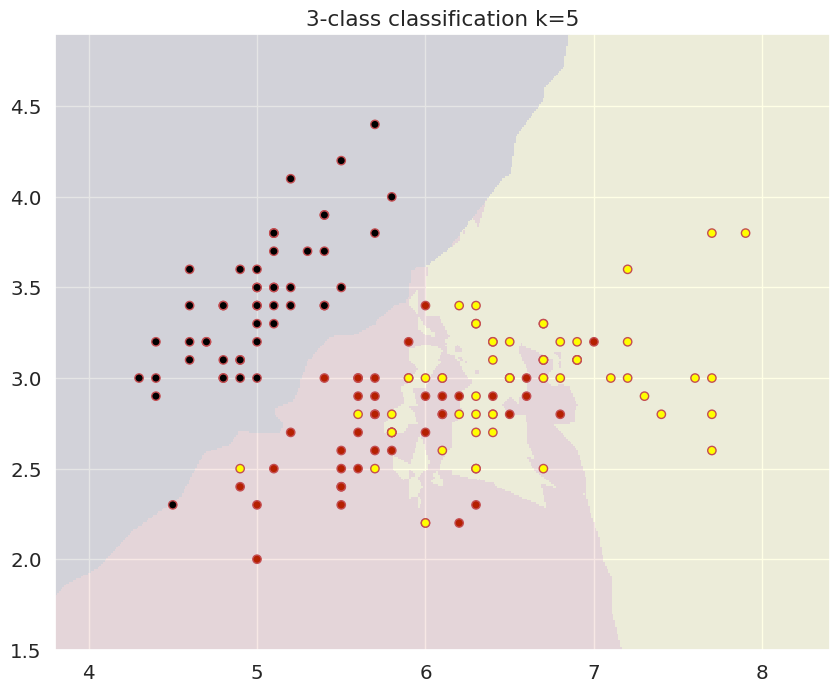

In [20]:
#wykres granic decyzyjnych

x_min, x_max = data[:, 0].min() - 0.5, data[:, 0].max() + 0.5
y_min, y_max = data[:, 1].min() - 0.5, data[:, 1].max() + 0.5

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
mesh = np.c_[xx.ravel(), yy.ravel()]
Z = classifier.predict(mesh)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.pcolormesh(xx, yy, Z, cmap='gnuplot', alpha=0.1)
plt.scatter(data[:, 0], data[:, 1], c=target, cmap='gnuplot', edgecolors='r')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('3-class classification k=5')
plt.show()

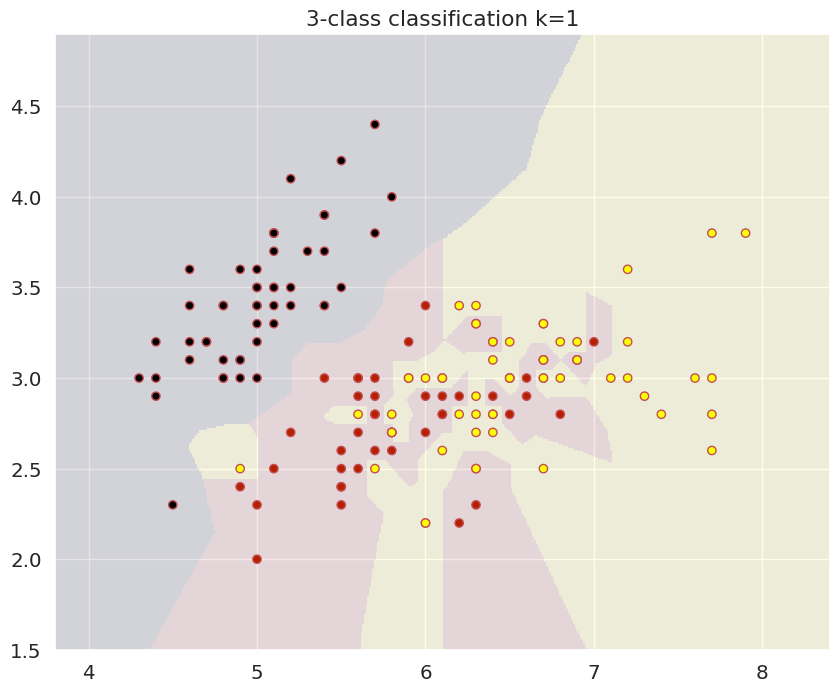

In [22]:
#funkcja pomagająca zautomatyzowąc wykres u góry

def plot_decision_boundries(n_neighbors = 1):
  classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
  classifier.fit(data, target)

  x_min, x_max = data[:, 0].min() - 0.5, data[:, 0].max() + 0.5
  y_min, y_max = data[:, 1].min() - 0.5, data[:, 1].max() + 0.5

  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
  mesh = np.c_[xx.ravel(), yy.ravel()]
  Z = classifier.predict(mesh)
  Z = Z.reshape(xx.shape)

  plt.figure(figsize=(10, 8))
  plt.pcolormesh(xx, yy, Z, cmap='gnuplot', alpha=0.1)
  plt.scatter(data[:, 0], data[:, 1], c=target, cmap='gnuplot', edgecolors='r')
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  plt.title(f'3-class classification k={n_neighbors}')
  plt.show()

plot_decision_boundries()

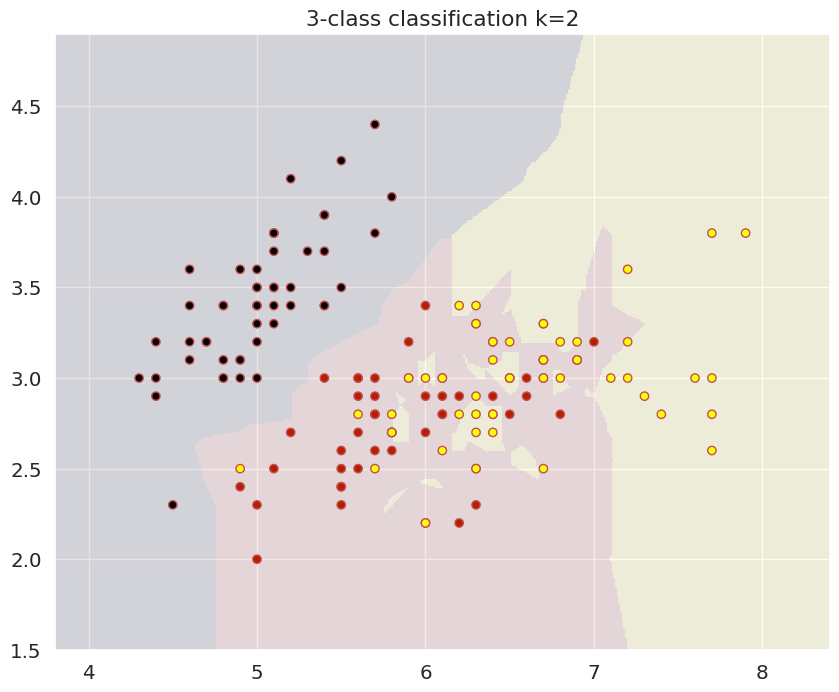

In [23]:
plot_decision_boundries(2)

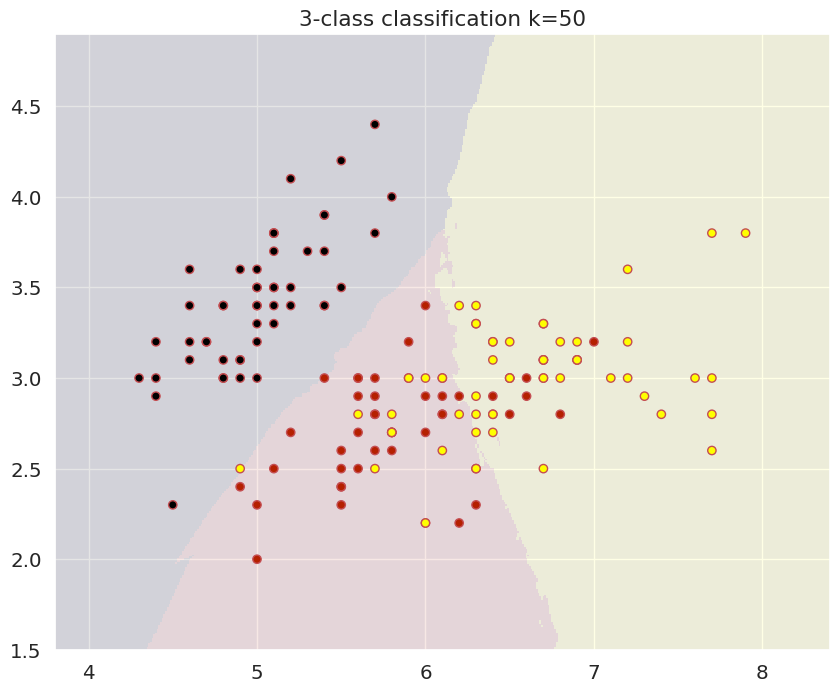

In [24]:
plot_decision_boundries(50)

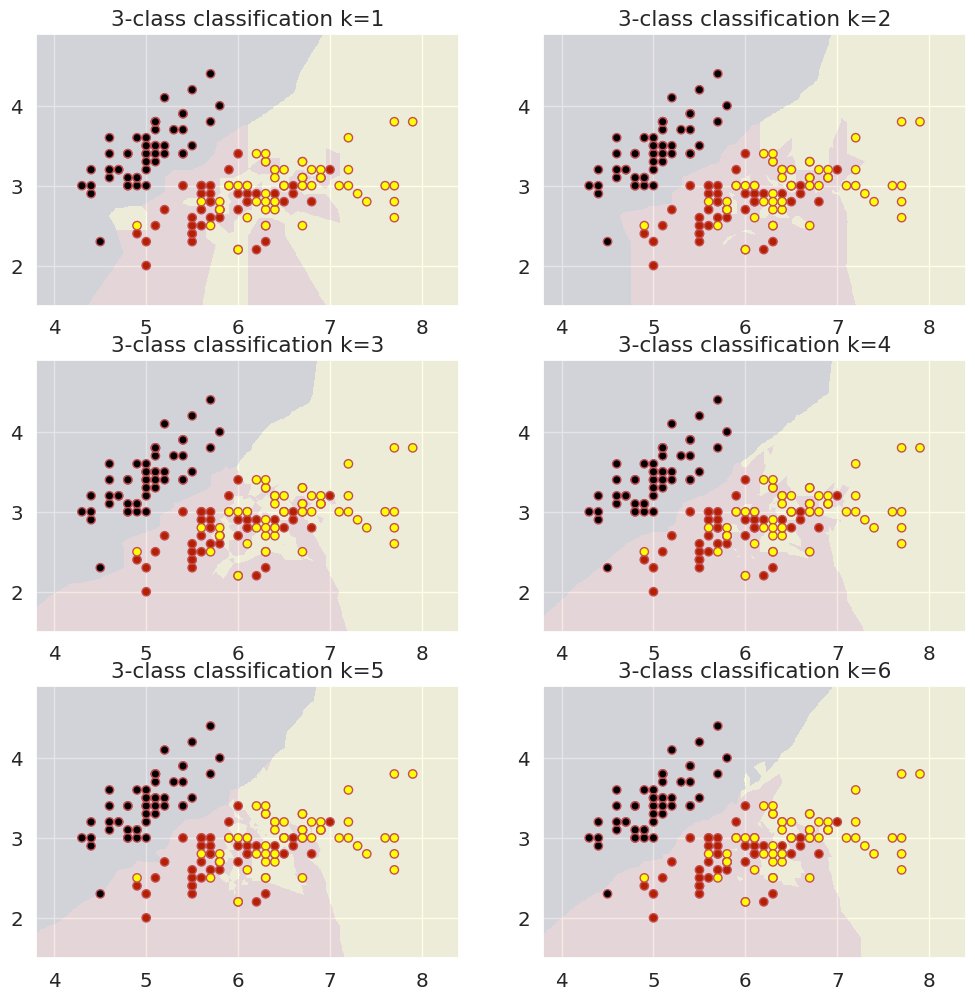

In [27]:
#porównanie wartości dla kilku parametrów k

plt.figure(figsize=(12,12))

for i in range(1,7):
  plt.subplot(3 , 2, i)

  clf = KNeighborsClassifier(n_neighbors=i)
  clf.fit(data,target)

  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
  mesh = np.c_[xx.ravel(), yy.ravel()]
  Z = clf.predict(mesh)
  Z = Z.reshape(xx.shape)

  plt.pcolormesh(xx, yy, Z, cmap='gnuplot', alpha=0.1)
  plt.scatter(data[:, 0], data[:, 1], c=target, cmap='gnuplot', edgecolors='r')
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  plt.title(f'3-class classification k={i}')

plt.show()